In [1]:
from getdist import plots, MCSamples
%matplotlib inline
from matplotlib import pyplot as plt
import getdist
import numpy as np
import os

In [2]:
DCOLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Galaxy density distribution per $z$-bin

In [45]:
dndz_redmagic = []
dndz_metacal = []
dndz_im3shape = []

zbins_gc = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
zbins_wl = [0.2, 0.43, 0.63, 0.9, 1.3]

for i in range(5):
    dndz_redmagic.append(np.loadtxt('/mnt/extraspace/damonge/S8z_data/derived_products/des_clustering/dndz_bin{}.txt'.format(i)))

for i in range(4):
    dndz_metacal.append(np.loadtxt('/mnt/extraspace/damonge/S8z_data/derived_products/des_shear/dndz_metacal_bin{}.txt'.format(i)))
    dndz_im3shape.append(np.loadtxt('/mnt/extraspace/damonge/S8z_data/derived_products/des_shear/dndz_im3shape_bin{}.txt'.format(i)))

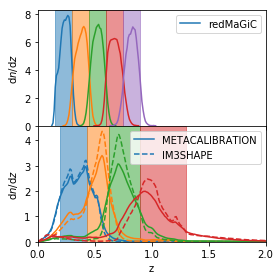

In [75]:
f, axs = plt.subplots(2, 1, figsize=(4, 4), sharex=True, gridspec_kw={'hspace':0, 'wspace':0})

for i, dndzi in enumerate(dndz_redmagic):
    sel = dndzi[:, -1] > 5e-3
    axs[0].plot(dndzi[sel, 1], dndzi[sel, -1], c=DCOLORS[i], label='redMaGiC' if not i else '')
    axs[0].axvspan(zbins_gc[i], zbins_gc[i+1], color=DCOLORS[i], alpha=0.5)

for i, dndzi in enumerate(dndz_metacal):
    axs[1].plot(dndzi[:,1], dndzi[:, -1], c=DCOLORS[i], label='METACALIBRATION' if not i else '')
    axs[1].plot(dndz_im3shape[i][:,1], dndz_im3shape[i][:, -1], c=DCOLORS[i], ls='--', label='IM3SHAPE'if not i else '')
    axs[1].axvspan(zbins_wl[i], zbins_wl[i+1], color=DCOLORS[i], alpha=0.5)

axs[0].legend(loc=0)
axs[1].legend(loc=1)

axs[0].set_ylim([0, None])
axs[1].set_ylim([0, None])

axs[0].set_ylabel('$\mathrm{d}n/\mathrm{d}z$')
axs[1].set_ylabel('$\mathrm{d}n/\mathrm{d}z$')
axs[1].set_xlabel('z')

plt.xlim([0, 2])
plt.tight_layout()
plt.savefig('./figures/dndz-bins.pdf')
plt.show()
plt.close()

# $C_\ell$

In [3]:
def load_thcls(th_outdir, file_prefix, nmaps):
    cls_arr = []
    for i in range(nmaps):
        for j in range(i, nmaps):
            fname = os.path.join(th_outdir, file_prefix + '_{}_{}.txt'.format(i, j))
            if not os.path.isfile(fname): #spin0-spin0
                raise ValueError('Missing workspace: ', fname)

            cls_arr.append(np.loadtxt(fname, usecols=1))

    ell = np.loadtxt(fname, usecols=0)

    return ell, np.array(cls_arr)

def load_thcls_gk(nmaps_g, nmaps_k):
    th_outdir = '/mnt/extraspace/evam/S8z/Clsgk/'
    file_prefix = 'DES_Cls_gk_lmax3xNside'
    cls_arr = []
    for i in range(nmaps_g):
        for j in range(nmaps_k):
            fname = os.path.join(th_outdir, file_prefix + '_{}_{}.txt'.format(i, j))
            if not os.path.isfile(fname): #spin0-spin0
                raise ValueError('Missing workspace: ', fname)

            cls_arr.append(np.loadtxt(fname, usecols=1))

    ell = np.loadtxt(fname, usecols=0)

    return ell, np.array(cls_arr)

def load_thcls_Planck():
    fdir = '/mnt/extraspace/evam/S8z/ClsPlanck/'
    cls_arr = []
    for i in range(5):
        fname = os.path.join(fdir, 'DESPlanck_Cls_gk_lmax3xNside_{}.txt'.format(i))
        cls_arr.append(np.loadtxt(fname, usecols=1))
    for i in range(4):
        fname = os.path.join(fdir, 'DESPlanck_Cls_kk_lmax3xNside_{}.txt'.format(i))
        cls_arr.append(np.loadtxt(fname, usecols=1)) 
        cls_arr.append(cls_arr[-1] * 0)

    fname = os.path.join(fdir, 'Planck_Cls_kk_lmax3xNside.txt'.format(i))
    cls_arr.append(np.loadtxt(fname, usecols=1))
    ell = np.loadtxt(fname, usecols=0)
    
    return ell, np.array(cls_arr)

def load_cls_all_matrix_th():
    # All th_ell are the same
    th_outdir = '/mnt/extraspace/evam/S8z/Clsgg/'
    th_ell, Clsgg_ar = load_thcls(th_outdir, 'DES_Cls_lmax3xNside', 5)

    th_outdir = '/mnt/extraspace/evam/S8z/Clskk/'
    th_ell, Clskk_ar = load_thcls(th_outdir, 'DES_Cls_kk_lmax3xNside', 4)

    th_outdir = '/mnt/extraspace/evam/S8z/Clsgk/'
    th_ell, Clsgk_ar = load_thcls_gk(5, 4)

    th_outdir = '/mnt/extraspace/evam/S8z/ClsPlanck/'
    th_ell, ClsPlanck_ar = load_thcls_Planck()
    
    # Checked that all EE's are the same as in the array.
    Clskk_full_mat = np.zeros((8, 8, th_ell.shape[0]))
    i, j = np.triu_indices(4)
    Clskk_full_mat[::2, ::2][i, j] = Clskk_ar
    Clskk_full_mat[::2, ::2][j, i] = Clskk_ar
    i, j = np.triu_indices(8)
    Clskk_ar_full = Clskk_full_mat[i, j]
    
    th_cls_all = np.zeros((14, 14, th_ell.shape[0]))

    i, j = np.triu_indices(5)
    th_cls_all[:5, :5][i, j] = Clsgg_ar

    i, j = np.triu_indices(8)
    th_cls_all[5:-1, 5:-1][i, j] = Clskk_ar_full

    th_cls_all[:, -1] = ClsPlanck_ar

    for i in range(5):
        th_cls_all[i, 5:-1:2] = Clsgk_ar[i * 4 : (i + 1) * 4]

    i, j = np.triu_indices(14)
    th_cls_all_ar = th_cls_all[i, j]
    th_cls_all[j, i] = th_cls_all_ar
    
    return th_ell, th_cls_all

### We could import the autocorr and plot the cls with their error.
def load_thErrors():
    outdir = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together/' 
    surveys = ['DESgc', 'DESwl', 'PLAcv']
    dsets = []
    for i in range(5):
        dsets.append(surveys[0] + str(i))
    for i in range(4):
        dsets.append(surveys[1] + str(i))
        
    dsets.append(surveys[2])
    
    th_err = []
    for c1, d1 in enumerate(dsets):
        for d2 in dsets[c1:]:
            fname = os.path.join(outdir, 'cov_{0}_{1}_{0}_{1}.npz'.format(d1, d2))
            th_err.append(np.sqrt(np.diag(np.load(fname)['arr_0'])))
    return np.array(th_err)


In [4]:
th_err = load_thErrors()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


In [5]:
th_err.shape

(55, 39)

In [6]:
############# Load theory cl matrix 

th_ell, th_cls_all = load_cls_all_matrix_th()

############# Load obs. cl matrix

outdir = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together/' 

lbpw_obs_cls_all = np.load(os.path.join(outdir, 'cl_all_no_noise.npz'))
lbpw, obs_cls_all = lbpw_obs_cls_all['l'], lbpw_obs_cls_all['cls']

lbpw_obs_cls_all = np.load(os.path.join(outdir, 'cl_all_with_noise.npz'))
lbpw, obs_cls_all_wn = lbpw_obs_cls_all['l'], lbpw_obs_cls_all['cls']

############### Load DES sh. noise

outdir = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together/' 
desgc_nls_arr = np.load(os.path.join(outdir, 'des_w_cl_shot_noise_ns4096.npz'))['cls']
dessh_nls_arr = np.load(os.path.join(outdir, 'des_sh_metacal_rot0-10_noise_ns4096.npz'))['cls']

############### Load Theoretical errors
th_err = load_thErrors()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


1.9675039393930176
8.67393638621147
7.349664242311528
5.790025375784253
3.899118776676901
4.778754840885101
2.551047184674564
8.540491652683913
3.261309284905762
1.6076428434368568
3.868426400320144
1.746838311120116
5.119017854332052
3.4739363325946195


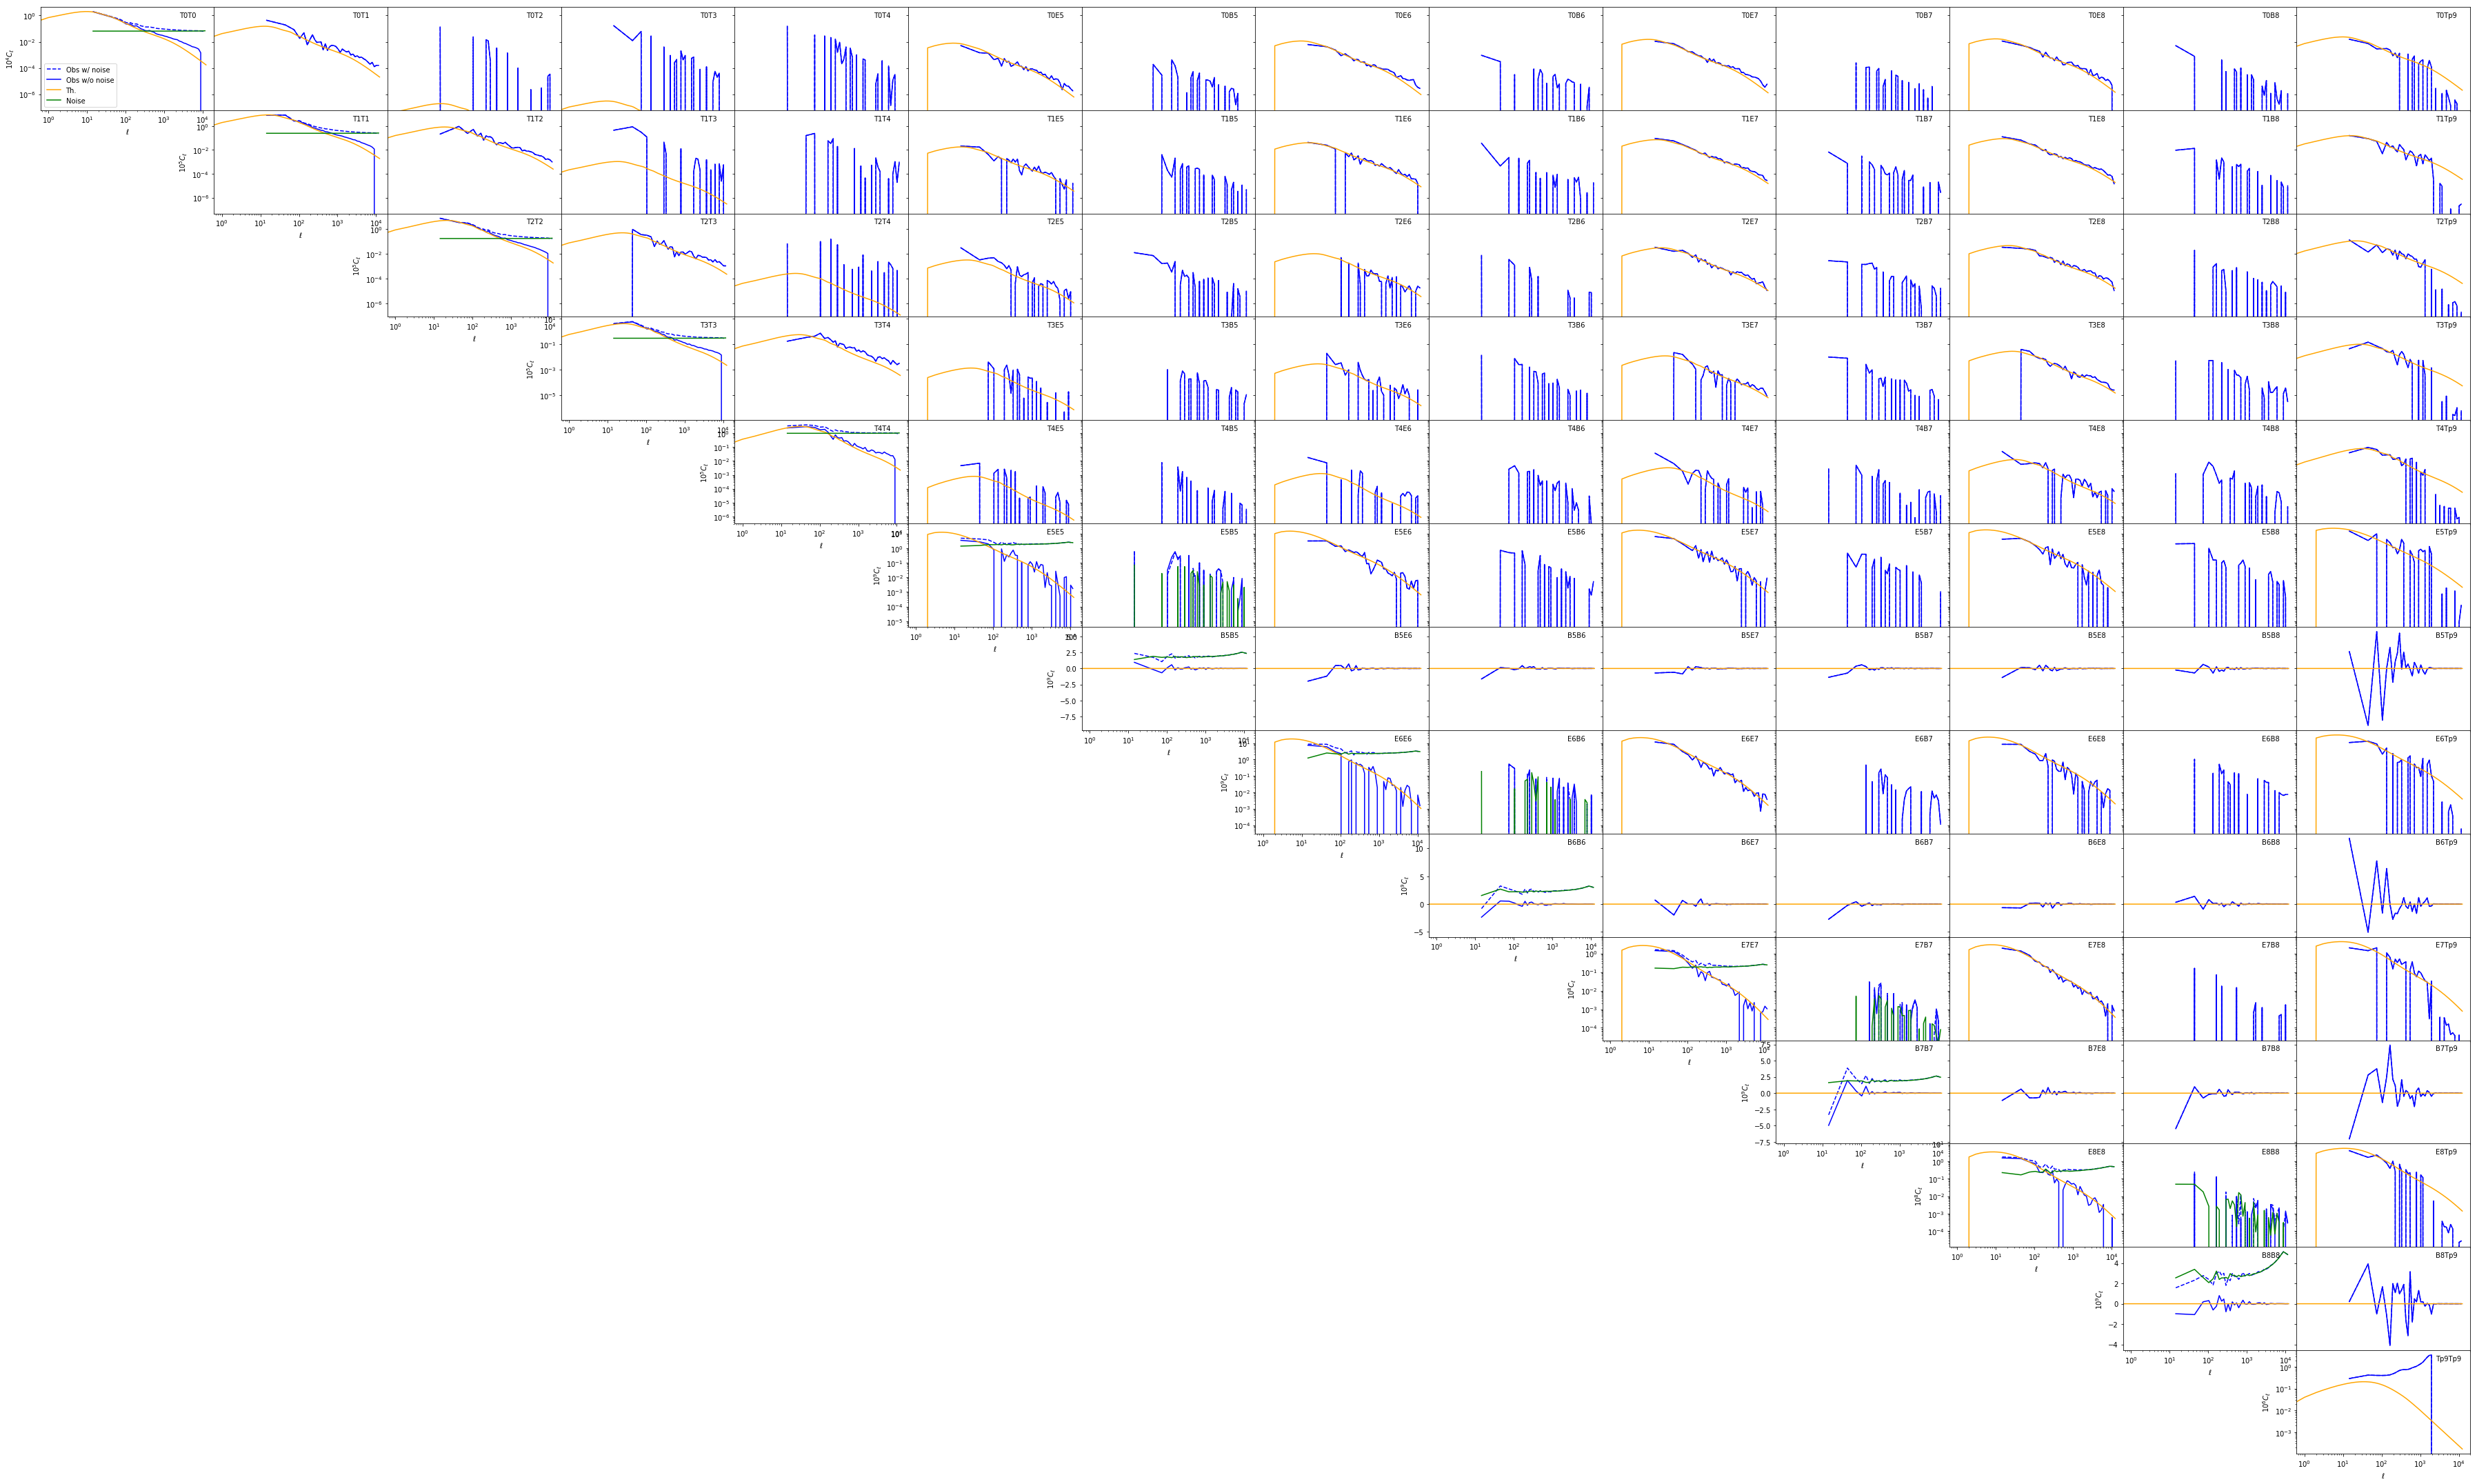

In [7]:
f, axs = plt.subplots(14, 14, figsize=(50, 30), sharex=True, sharey='row', gridspec_kw={'hspace':0, 'wspace':0})

labels = ['T0', 'T1', 'T2', 'T3', 'T4', 'E5', 'B5', 'E6', 'B6', 'E7', 'B7', 'E8', 'B8', 'Tp9']


ordmag = np.zeros(14)

for i in range(14):
    floor = - np.floor(np.log10(np.max(obs_cls_all_wn[i, i])))
    ordmag[i] = 10 ** floor
    
    for j in range(i, 14):
        axs[i, j].semilogx(lbpw, obs_cls_all_wn[i, j] * ordmag[i], c='blue', ls='--', label='Obs w/ noise')
        axs[i, j].semilogx(lbpw, obs_cls_all[i, j] * ordmag[i], c='blue', label='Obs w/o noise')
        axs[i, j].semilogx(th_ell, th_cls_all[i, j] * ordmag[i], c='orange', label='Th.')
        if not np.all(th_cls_all[i, j] == 0):
            axs[i, j].set_yscale('log')
            
        axs[i, j].text(0.8, 0.9, labels[i] + labels[j],  transform=axs[i,j].transAxes)
        
        if i != j:
            axs[j, i].set_visible(False)
        else:
            print(np.max(np.abs(obs_cls_all_wn[i, i])) * ordmag[i])
            axs[i, i].set_xlabel(r'$\ell$')
            axs[i, i].set_ylabel(r'$10^{{ {} }} C_{{\ell}}$'.format(int(floor)))
            axs[i, i].xaxis.set_tick_params(which='both', labelbottom=True)
            axs[i, i].yaxis.set_tick_params(which='both', labelbottom=True)

        
for i in range(5):   
    axs[i, i].semilogx(lbpw, desgc_nls_arr[i] * ordmag[i], c='green', label='Noise')

for i in range(4):
    ixplot = 5 + i * 2
    
    axs[ixplot, ixplot].semilogx(lbpw, dessh_nls_arr[i, 0, 0] * ordmag[ixplot], c='green', label='Noise')
    axs[ixplot, ixplot + 1].semilogx(lbpw, dessh_nls_arr[i, 0, 1] * ordmag[ixplot], c='green', label='Noise')
    axs[ixplot + 1, ixplot + 1].semilogx(lbpw, dessh_nls_arr[i, 1, 1] * ordmag[ixplot + 1], c='green', label='Noise')



axs[0,0].legend(loc=0)
plt.tight_layout()
plt.savefig('figures/cls_all.pdf')
plt.show()
plt.close()

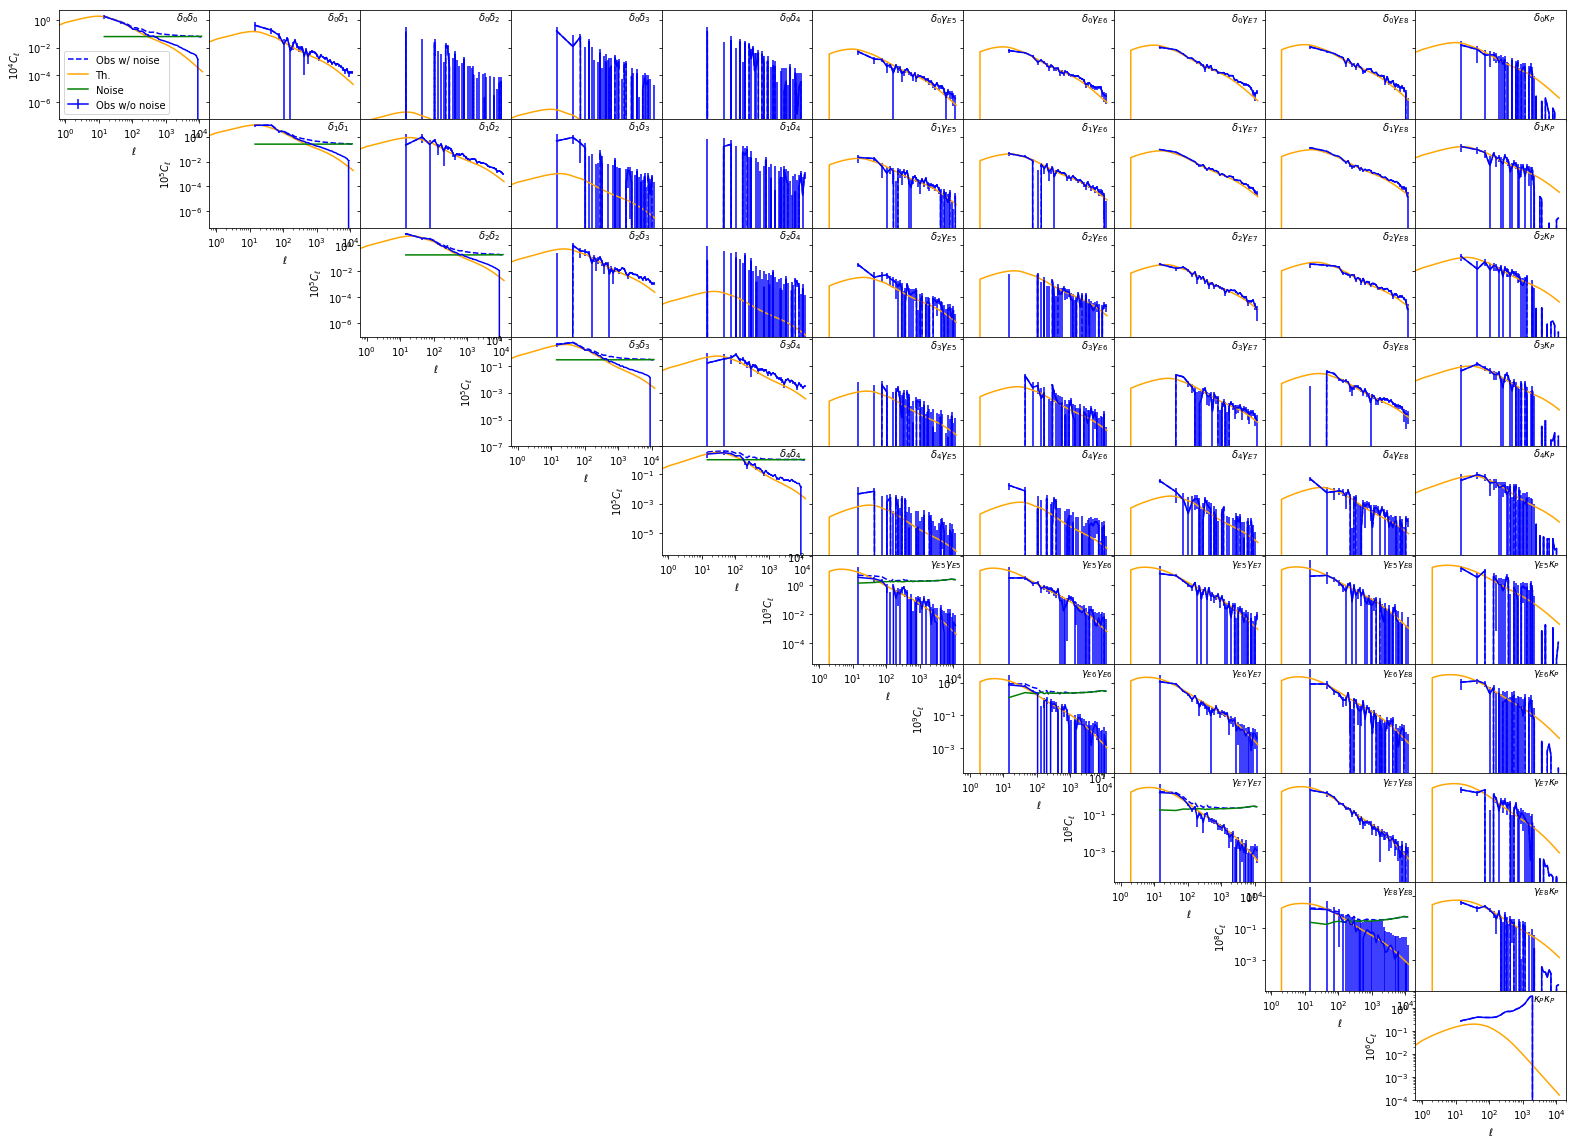

In [47]:
f, axs = plt.subplots(10, 10, figsize=(22, 16), sharex=True, sharey='row', gridspec_kw={'hspace':0, 'wspace':0})

labels = ['\delta_0', '\delta_1', '\delta_2', '\delta_3', '\delta_4',
          '\gamma_{E5}', '\gamma_{B5}', '\gamma_{E6}', '\gamma_{B6}', 
          '\gamma_{E7}', '\gamma_{B7}', '\gamma_{E8}', '\gamma_{B8}', 
          '\kappa_P']


ordmag = np.zeros(14)

ixplot = jxplot = 0
count = 0
for i in range(14):
    if 'B' in labels[i]:
        continue
    floor = - np.floor(np.log10(np.max(obs_cls_all_wn[i, i])))
    ordmag[i] = 10 ** floor
    
    jxplot = ixplot
    for j in range(i, 14):
        if 'B' in labels[j]:
            continue
            
        axs[ixplot, jxplot].semilogx(lbpw, obs_cls_all_wn[i, j] * ordmag[i], c='blue', ls='--', label='Obs w/ noise')
        # axs[ixplot, jxplot].semilogx(lbpw, obs_cls_all[i, j] * ordmag[i], c='blue', label='Obs w/o noise')
        axs[ixplot, jxplot].errorbar(lbpw, obs_cls_all[i, j] * ordmag[i], yerr=th_err[count] * ordmag[i],
                                     c='blue', label='Obs w/o noise')
        axs[ixplot, jxplot].semilogx(th_ell, th_cls_all[i, j] * ordmag[i], c='orange', label='Th.')
        if not np.all(th_cls_all[i, j] == 0):
            axs[ixplot, jxplot].set_yscale('log')
            
        axs[ixplot, jxplot].text(0.78, 0.9, '${}$'.format(labels[i] + labels[j]),
                                 transform=axs[ixplot,jxplot].transAxes)
        
        if i != j:
            axs[jxplot, ixplot].set_visible(False)
        else:
            axs[ixplot, ixplot].set_xlabel(r'$\ell$')
            axs[ixplot, ixplot].set_ylabel(r'$10^{{ {} }} C_{{\ell}}$'.format(int(floor)))
            axs[ixplot, ixplot].xaxis.set_tick_params(which='both', labelbottom=True)
            axs[ixplot, ixplot].yaxis.set_tick_params(which='both', labelbottom=True)
            
        jxplot += 1
        count += 1
    ixplot += 1

        
for i in range(5):   
    axs[i, i].semilogx(lbpw, desgc_nls_arr[i] * ordmag[i], c='green', label='Noise')

for i in range(4):
    axs[5 + i, 5 + i].semilogx(lbpw, dessh_nls_arr[i, 0, 0] * ordmag[5 + i * 2 ], c='green', label='Noise')


axs[0,0].legend(loc=0)
plt.tight_layout()
plt.savefig('figures/cls_all_noBs.pdf')
plt.show()
plt.close()

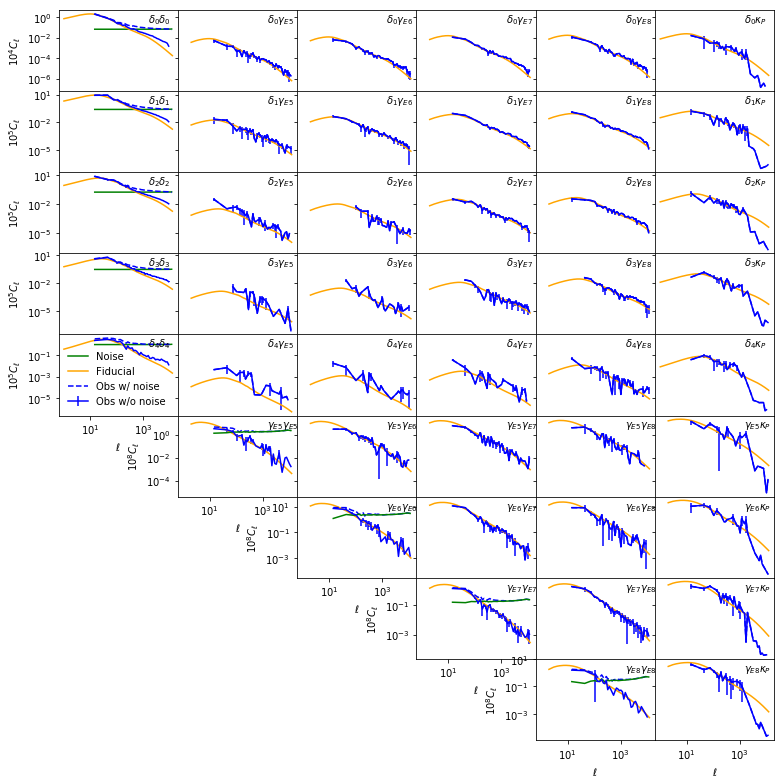

In [90]:
def ax_plot(ax, i, j, count, labels, text=True):
    floor = - np.floor(np.log10(np.max(obs_cls_all_wn[i, i])))
    ordmag = 10 ** floor
    
    sel = th_cls_all[i,j]>0
    ax.semilogx(th_ell[sel], th_cls_all[i, j, sel] * ordmag, c='orange', label='Fiducial')
    sel = obs_cls_all_wn[i,j]>0
    ax.semilogx(lbpw[sel], obs_cls_all_wn[i, j, sel] * ordmag, c='blue', ls='--', label='Obs w/ noise')
    sel = obs_cls_all[i,j]>0
    ax.errorbar(lbpw[sel], obs_cls_all[i, j, sel] * ordmag, yerr=th_err[count, sel] * ordmag,
                                   c='blue', label='Obs w/o noise')
    
    if not np.all(th_cls_all[i, j] == 0):
        ax.set_yscale('log')

    if text:
        ax.text(0.75, 0.85, '${}$'.format(labels[i] + labels[j]),
                                 transform=ax.transAxes)
    return floor, ordmag


f, axs = plt.subplots(9, 6, figsize=(11, 11), sharex=True, sharey='row', gridspec_kw={'hspace':0, 'wspace':0})

labels = ['\delta_0', '\delta_1', '\delta_2', '\delta_3', '\delta_4',
          '\gamma_{E5}', '\gamma_{B5}', '\gamma_{E6}', '\gamma_{B6}', 
          '\gamma_{E7}', '\gamma_{B7}', '\gamma_{E8}', '\gamma_{B8}', 
          '\kappa_P']

count = 0
for i in range(5):
    count += 10 - i
    floor = - np.floor(np.log10(np.max(obs_cls_all_wn[i, i])))
    ordmag = 10 ** floor
    axs[i, 0].semilogx(lbpw, desgc_nls_arr[i] * ordmag, c='green', label='Noise')
    floor, ordmag = ax_plot(axs[i, 0], i, i, count, labels)
    axs[i, 0].set_ylabel(r'$10^{{ {} }} C_{{\ell}}$'.format(int(floor)))
axs[i, 0].set_xlabel(r'$\ell$')
axs[i, 0].xaxis.set_tick_params(which='both', labelbottom=True)


ixplot = 0
jxplot = 1
count = 0
for i in range(13):
    if 'B' in labels[i]:
        continue

    if ixplot > 4:
        jxplot = ixplot - 4
    else:
        jxplot = 1
    for j in range(i, 14):
        if 'B' in labels[j]:
            continue
        if ('delta' in labels[i]) and ('delta' in labels[j]):
            count += 1
            continue
        floor, ordmag = ax_plot(axs[ixplot, jxplot], i, j, count, labels)
        
        jxplot += 1
        count += 1
    ixplot += 1

        
for i in range(4):
    floor = - np.floor(np.log10(np.max(obs_cls_all_wn[5 + i*2, 5 + i * 2])))
    ordmag = 10 ** floor
    axs[5 + i, 1 + i].semilogx(lbpw, dessh_nls_arr[i, 0, 0] * ordmag, c='green', label='Noise')

for ixplot in range(5, 9):
    for jxplot in range(6):
        if (ixplot > 4) and (jxplot < ixplot - 4):
            axs[ixplot, jxplot].set_visible(False)
        if (ixplot > 4) and (jxplot == ixplot - 4):
            axs[ixplot, jxplot].set_xlabel(r'$\ell$')
            axs[ixplot, jxplot].set_ylabel(r'$10^{{ {} }} C_{{\ell}}$'.format(int(floor)))
            axs[ixplot, jxplot].xaxis.set_tick_params(which='both', labelbottom=True)
            axs[ixplot, jxplot].yaxis.set_tick_params(which='both', labelbottom=True)
axs[8, 5].set_xlabel(r'$\ell$')
            
axs[4,0].legend(loc='bottom left', frameon=False)

plt.tight_layout()
plt.savefig('figures/cls_lkl.pdf')
plt.show()
plt.close()

# MCMC

In [4]:
MP_root = '/mnt/zfsusers/gravityls_3/codes/montepython_emilio'

## DES and Growth modified (dpk1 free) instances

In [5]:
des_root = os.path.join(MP_root, 'chains/cl_cross_corr_des_full_kappa_l8/')
des = getdist.loadMCSamples(os.path.join(des_root, '2020-03-09_1000000_'),
                           settings={'ignore_rows':0.02})

growth_root = os.path.join(MP_root, 'chains/cl_cross_corr_des_growth_dpk0_fixed_kappa_l8/')
growth = getdist.loadMCSamples(os.path.join(growth_root, '2020-03-09_1000000_'),
                           settings={'ignore_rows':0.02})

In [5]:
print(des.getGelmanRubin())
print(growth.getGelmanRubin())

0.010423998180182671
0.03258282425457293


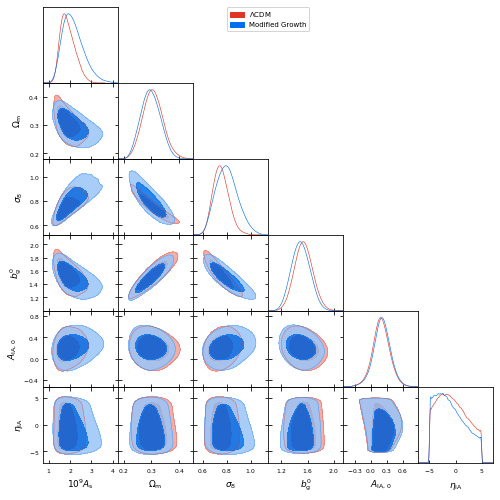

In [6]:
g = plots.get_subplot_plotter(width_inch=7)
g.triangle_plot([des, growth], params=['A_s', 'Omega_m', 'sigma_8', 'gc_b_0', 'wl_ia_A','wl_ia_eta'],
                filled=True, legend_labels=[r'$\Lambda$CDM', 'Modified Growth'])
g.export('./figures/mcmc_des_and_growth_dpk0_fixed.pdf')
g.finish_plot()

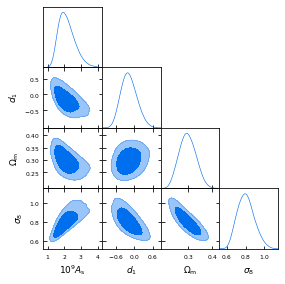

In [7]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot([growth], params=['A_s', 'dpk1', 'Omega_m', 'sigma_8'],
                filled=True)
g.export('./figures/mcmc_growth_dpk0_fixed.pdf')
g.finish_plot()

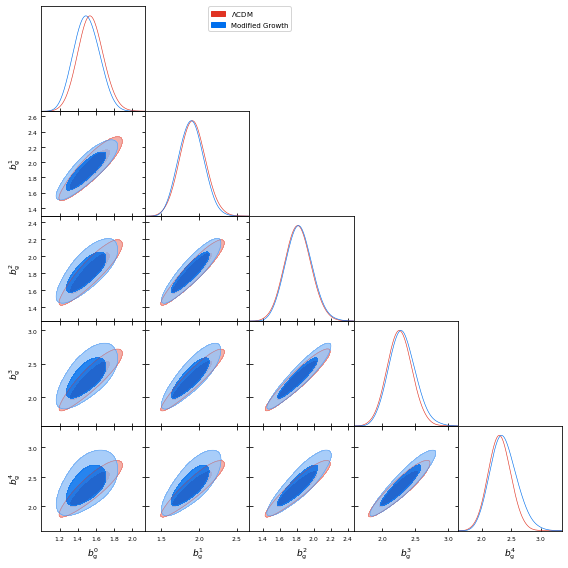

In [8]:
g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot([des, growth], params=['gc_b_0', 'gc_b_1', 'gc_b_2', 'gc_b_3', 'gc_b_4'],
                filled=True, legend_labels=[r'$\Lambda$CDM', 'Modified Growth'])
g.finish_plot()

In [9]:
des_latex = des.getLatex()
growth_latex = growth.getLatex()
print(growth_latex[0][0], growth_latex[1][0])
print 'Parameter', 'DES', 'GROWTH'
for i in zip(des_latex[0], des_latex[1], growth_latex[1][1:]):
    print i

('d_1', '-0.18^{+0.23}_{-0.29}')
Parameter DES GROWTH
('\\Omega_{\\rm b}', '0.0434^{+0.0048}_{-0.013}', '0.0422^{+0.0038}_{-0.012}')
('\\Omega_{\\rm c}', '0.262\\pm 0.034', '0.255\\pm 0.032')
('10^{9}A_{\\rm s}', '1.89^{+0.25}_{-0.42}', '2.14^{+0.35}_{-0.59}')
('n_{\\rm s}', '0.955^{+0.039}_{-0.080}', '0.958^{+0.045}_{-0.082}')
('h', '0.657^{+0.032}_{-0.11}', '0.667^{+0.039}_{-0.11}')
('b_{\\rm g}^{0}', '1.54\\pm 0.14', '1.50\\pm 0.14')
('b_{\\rm g}^{1}', '1.92\\pm 0.17', '1.90\\pm 0.16')
('b_{\\rm g}^{2}', '1.81\\pm 0.16', '1.82\\pm 0.16')
('b_{\\rm g}^{3}', '2.26\\pm 0.19', '2.30^{+0.19}_{-0.21}')
('b_{\\rm g}^{4}', '2.30\\pm 0.19', '2.38^{+0.20}_{-0.25}')
('\\Delta z^0_{\\rm g}', '-0.0059\\pm 0.0066', '-0.0057\\pm 0.0066')
('\\Delta z^1_{\\rm g}', '0.0040\\pm 0.0065', '0.0045\\pm 0.0066')
('\\Delta z^2_{\\rm g}', '-0.0020\\pm 0.0057', '-0.0017\\pm 0.0057')
('\\Delta z^3_{\\rm g}', '0.0015\\pm 0.0091', '0.0021\\pm 0.0091')
('\\Delta z^4_{\\rm g}', '0.0033\\pm 0.0098', '0.0033\\pm 0.0

### Growth change

In [11]:
import pyccl as ccl

In [12]:
def S8(mcmc, cosmo, a, origin='mean'):
    means = mcmc.getMeans()
    stats = mcmc.density1D
    if origin == 'mean':
        sigma8 = means[-3] # ccl.sigma8(cosmo)
    elif origin == 'down':
        sigma8 = stats['sigma_8'].getLimits([0.68])[0]
    elif origin == 'up':
        sigma8 = stats['sigma_8'].getLimits([0.68])[1]
    elif origin == 'CCL': 
        sigma8 = ccl.sigma8(cosmo)
    Dz = ccl.background.growth_factor(cosmo, a)
    sigma8z = Dz * sigma8
    Om = ccl.background.omega_x(cosmo, 1, 'matter')
    
    return sigma8z * (Om / 0.3)**(0.5)

def z_from_a(a):
    return 1./a - 1

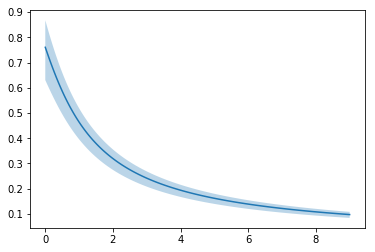

In [13]:
means = des.getMeans()
des.getLatex()  # Seems to be necessary to get all variables in density1D
stats = des.density1D

# Initialize the cosmology class
des_cosmo = ccl.Cosmology(h=means[4], Omega_c=means[1], Omega_b=means[0],
                        A_s=1e-9*means[2], n_s=means[3],
                        w0=-1, wa=0,
                        transfer_function='boltzmann_class')
des_cosmo_dn = ccl.Cosmology(h=stats['h'].getLimits([0.68])[0],
                             Omega_c=stats['Omega_c'].getLimits([0.68])[0],
                             Omega_b=stats['Omega_b'].getLimits([0.68])[0],
                             A_s=1e-9*stats['A_s'].getLimits([0.68])[0],
                             n_s=stats['n_s'].getLimits([0.68])[0],
                             w0=-1, wa=0,
                             transfer_function='boltzmann_class')
des_cosmo_up = ccl.Cosmology(h=stats['h'].getLimits([0.68])[1],
                             Omega_c=stats['Omega_c'].getLimits([0.68])[1],
                             Omega_b=stats['Omega_b'].getLimits([0.68])[1],
                             A_s=1e-9*stats['A_s'].getLimits([0.68])[1],
                             n_s=stats['n_s'].getLimits([0.68])[1],
                             w0=-1, wa=0,
                             transfer_function='boltzmann_class')

# Compute everything
ccl.sigma8(des_cosmo)
ccl.sigma8(des_cosmo_dn)
ccl.sigma8(des_cosmo_up)

# Compute S8

a = np.logspace(0, -1, 100)
S8des = S8(des, des_cosmo, a, 'mean')
S8des_up = S8(des, des_cosmo_up, a, 'up')
S8des_dn = S8(des, des_cosmo_dn, a, 'down')

# Plot it with 1sigma CL
Z = z_from_a(a)
f, ax = plt.subplots(1,1, sharex=True, gridspec_kw={'hspace':0})
ax.fill_between(Z, S8des_up, S8des_dn, alpha=0.3)
ax.plot(Z, S8des)
plt.show()

# Show differences between CCL and GD
#a = np.logspace(0, -1, 10)
#S8des = S8(des, des_cosmo, a, 'mean')
#S8des2 = S8(des, des_cosmo, a, 'CCL')

#Z = z_from_a(a)
#f, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'hspace':0})
#axs[0].plot(Z, S8des2, label='CCL')
#axs[0].plot(Z, S8des, label='GD')
#axs[1].plot(Z, S8des2/S8des - 1)
#axs[1].set_xlabel(r'$z$')
#axs[0].set_ylabel(r'$S_8$ ')
#axs[1].set_ylabel(r'$S_8$ CCL / $S_8$ GD')
#axs[0].legend(loc=0)
#plt.show()

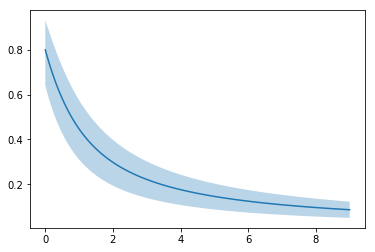

In [14]:
means = growth.getMeans()
growth.getLatex()  # Seems to be necessary to get all variables in density1D
stats = growth.density1D


#### Commented out because this way CCL does not change D(z), only the PO

# def pk2D_new(dpk1, pk, cosmo):
#     def pknew(k, a):
#         # return (1 + dpk1 * (1 - a)) ** 2 * pk.eval(k, a, cosmo)
#         return (1 + dpk1) ** 2 * pk.eval(k, a, cosmo)
#     return pknew


# def modify_growth(dpk1, cosmo):
#     pk = ccl.boltzmann.get_class_pk_lin(cosmo)
#     pknew = ccl.Pk2D(pkfunc=pk2D_new(dpk1, pk, cosmo), cosmo=cosmo, is_logp=False)
#     ccl.ccllib.cosmology_compute_linear_power(cosmo.cosmo, pknew.psp, 0)

# Initialize the cosmology class
# NOTE the change of index (+1 because dpk1 is now at 0)
growth_cosmo = ccl.Cosmology(h=means[5], Omega_c=means[2], Omega_b=means[1],
                        A_s=1e-9*means[3], n_s=means[4],
                        w0=-1, wa=0,
                        transfer_function='boltzmann_class')

growth_cosmo_dn = ccl.Cosmology(h=stats['h'].getLimits([0.68])[0],
                             Omega_c=stats['Omega_c'].getLimits([0.68])[0],
                             Omega_b=stats['Omega_b'].getLimits([0.68])[0],
                             A_s=1e-9*stats['A_s'].getLimits([0.68])[0],
                             n_s=stats['n_s'].getLimits([0.68])[0],
                             w0=-1, wa=0,
                             transfer_function='boltzmann_class')

growth_cosmo_up = ccl.Cosmology(h=stats['h'].getLimits([0.68])[1],
                             Omega_c=stats['Omega_c'].getLimits([0.68])[1],
                             Omega_b=stats['Omega_b'].getLimits([0.68])[1],
                             A_s=1e-9*stats['A_s'].getLimits([0.68])[1],
                             n_s=stats['n_s'].getLimits([0.68])[1],
                             w0=-1, wa=0,
                             transfer_function='boltzmann_class')

# Modify growth
d1_up = stats['dpk1'].getLimits([0.68])[1]
d1_dn = stats['dpk1'].getLimits([0.68])[0]
d1 = means[0]

# modify_growth(d1, growth_cosmo)
# modify_growth(d1_up, growth_cosmo_up)
# modify_growth(d1_dn, growth_cosmo_dn)

# Compute everything
ccl.sigma8(growth_cosmo)
ccl.sigma8(growth_cosmo_dn)
ccl.sigma8(growth_cosmo_up)

# Compute S8
a = np.logspace(0, -1, 100)
S8growth = (1 + d1 * (1 - a)) * S8(growth, growth_cosmo, a, 'mean')
S8growth_up = (1 + d1_up * (1 - a)) * S8(growth, growth_cosmo_up, a, 'up')
S8growth_dn = (1 + d1_dn * (1 - a)) * S8(growth, growth_cosmo_dn, a, 'down')

# Plot it with 1sigma CL
Z = z_from_a(a)
f, ax = plt.subplots(1,1, sharex=True, gridspec_kw={'hspace':0})
ax.fill_between(Z, S8growth_up, S8growth_dn, alpha=0.3)
ax.plot(Z, S8growth)

plt.show()

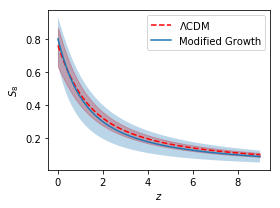

In [15]:
f, ax = plt.subplots(1,1, sharex=True, gridspec_kw={'hspace':0}, figsize=(4, 3))
ax.fill_between(Z, S8des_up, S8des_dn, color='r', alpha=0.3)
ax.plot(Z, S8des, '--', c='r',label=r'$\Lambda$CDM')
ax.fill_between(Z, S8growth_up, S8growth_dn, alpha=0.3)
ax.plot(Z, S8growth, label='Modified Growth')
ax.legend(loc=0)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$S_8$')
plt.tight_layout()
plt.savefig('./figures/S8z.pdf')
plt.show()

## Professional way

In [6]:
# S8z.npz computed with notebooks/S8z.py
des_S8z = np.load(os.path.join(des_root, 'S8z.npz'))
growth_S8z = np.load(os.path.join(growth_root, 'S8z.npz'))

In [7]:
des_S8_mean = np.mean(des_S8z['S8z'],axis=0)
growth_S8_mean = np.mean(growth_S8z['S8z'],axis=0)
des_S8_std = np.std(des_S8z['S8z'],axis=0)
growth_S8_std = np.std(growth_S8z['S8z'],axis=0)

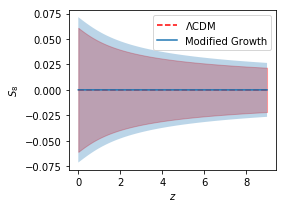

In [8]:
Z = 1/des_S8z['a'] - 1

S8des = des_S8_mean
S8growth = growth_S8_mean

S8des_up = S8des + np.sqrt(des_S8_std)
S8des_dn = S8des - np.sqrt(des_S8_std)

S8growth_up = S8growth + np.sqrt(growth_S8_std)
S8growth_dn = S8growth - np.sqrt(growth_S8_std)

f, ax = plt.subplots(1,1, sharex=True, gridspec_kw={'hspace':0}, figsize=(4, 3))
ax.fill_between(Z, S8des_up, S8des_dn, color='r', alpha=0.3)
ax.plot(Z, S8des, '--', c='r',label=r'$\Lambda$CDM')
ax.fill_between(Z, S8growth_up, S8growth_dn, alpha=0.3)
ax.plot(Z, S8growth, label='Modified Growth')
ax.legend(loc=0)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$S_8$')
plt.tight_layout()
# plt.savefig('./figures/S8z.pdf')
plt.show()